In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import sys
sys.path.append('/home/kaigorodov/myprojects/MedConcNorm/')

In [36]:
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from src.features.metrics import accuracy_top_K_pobs, sensitivity_area_K_range

X, y = load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [4]:
with open('../data/processed/pure_data.pkl', 'rb') as data_file:
    df = pickle.load(data_file)

In [5]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_test, y_train, y_test = df

In [37]:
results_df = pd.DataFrame()
sensitivity_model = []
for max_iter in [100, 200, 500, 800, 1000]:

    clf = make_pipeline(StandardScaler(),
                        SGDClassifier(max_iter=max_iter, tol=1e-3, loss='log'))
    clf.fit(X_train, y_train)

    y_pred = clf.predict_proba(X_test)
    sensitivity_model.append(sensitivity_area_K_range(y_test, y_pred))
                             
    print('unique classes in y:', np.unique(np.concatenate([y_train, y_test])).shape[0], end='\n'*2)

    print("default scoring:", clf.score(X_test, y_test))
    print("sensitivity:", sensitivity_model[-1])

    k_values, k_estims = [], []
    for k in range(1, 11):
        k_values.append(k)
        k_estims.append(accuracy_top_K_pobs(y_test, y_pred, k=k))
        #print(f"accuracy@{k}:", k_estims[-1])
    results_df[f"k"] = k_values
    results_df[f"accuracy_{max_iter}"] = k_estims
    
sensitivity_model_df = pd.DataFrame({'model': results_df.columns[1:], 'sense': sensitivity_model})
results_df = results_df.set_index('k')
results_df

unique classes in y: 472

default scoring: 0.10760667903525047
sensitivity: 1.6484230055658626
unique classes in y: 472

default scoring: 0.12430426716141002
sensitivity: 1.6103896103896105


KeyboardInterrupt: 

<AxesSubplot:xlabel='k'>

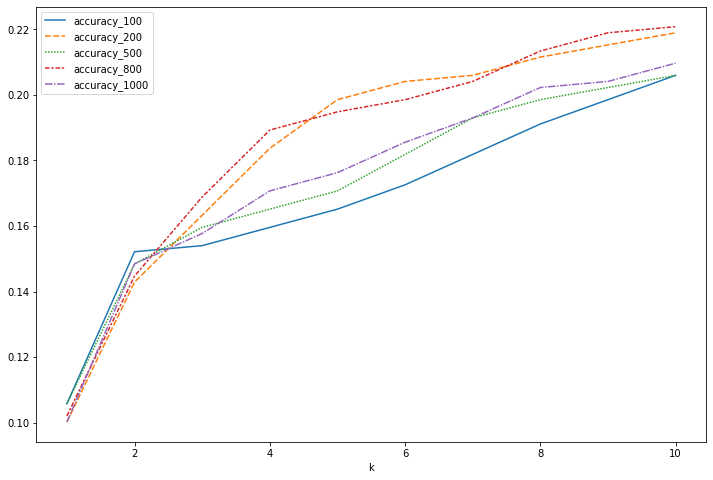

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df)

<AxesSubplot:xlabel='model', ylabel='sense'>

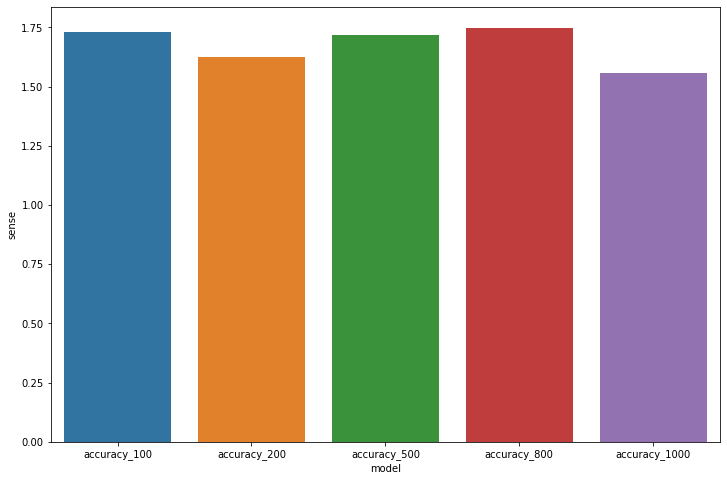

In [33]:
plt.figure(figsize=(12, 8))
sns.barplot(data=sensitivity_model_df, x='model', y='sense')